# Using CF-Xarray to easily analyze CMORized and non-CMORized output

This notebook demonstrates how to use CF attributes in datasets to write code that generalizes across datasets that follow different naming conventions

In [70]:
import cf_xarray as cfxr

import intake
import intake_esm

import matplotlib as mpl
import numpy as np
import xarray as xr
import pop_tools

import matplotlib.pyplot as plt

import metpy  # metpy's unit handling behaves better than pint-xarray for now
import pint_xarray

xr.set_options(keep_attrs=True)

In [4]:
import ncar_jobqueue
import distributed

cluster = ncar_jobqueue.NCARCluster(project="ncgd0048")
cluster.scale(6)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://10.12.1.2:44301 Dashboard: https://jupyterhub.ucar.edu/dav/user/dcherian/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## TODO: 

- [ ] read data with intake-esm
  `# intake.open_esm_datastore("/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json")`
- [ ] Add `pop_tools.add_cf_attributes()`

In [34]:
# CF attributes to add to POP output
cf_attrs = {
    "UVEL": {"standard_name": "sea_water_x_velocity", "cell_measures": "area: UAREA"},
    "VVEL": {"standard_name": "sea_water_y_velocity", "cell_measures": "area: UAREA"},
    "TEMP": {
        "standard_name": "sea_water_potential_temperature",
        "cell_measures": "area: TAREA",
    },
    "SALT": {"standard_name": "sea_water_salinity", "cell_measures": "area: TAREA"},
}


def set_coords(ds):
    """ Set nlat, nlon as coordinate variables and identify axis as X, Y"""
    ds["nlat"] = ("nlat", np.arange(ds.sizes["nlat"]), {"axis": "Y"})
    ds["nlon"] = ("nlon", np.arange(ds.sizes["nlon"]), {"axis": "X"})
    return ds

## Read Data

### CESM-POP

In [43]:
cesm = xr.open_mfdataset(
    "/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f09_g17.CMIP6-piControl.001/ocn/proc/tseries/month_1/b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.UVEL.*.nc",
    chunks={"time": 1000, "nlat": 100, "nlon": 10},
    parallel=True,
    data_vars="minimal",
    coords="minimal",
    compat="override",
)
cesm

<xarray.Dataset>
Dimensions:                 (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 24000, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                   (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
  * time                    (time) object 0001-02-01 00:00:00 ... 2001-01-01 ...
Dimensions without coordinates: d2, moc_comp, nlat, nlon, transport_comp, transport_reg
Data variables: (12/55)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
    ...                      ...
    salinity_factor         float64 ...
    sflux_factor            float64 ...
    nsurface_t              float64 ...
    nsurface_u              float64 ...
    time_bound              (time, d2) object dask.array<chunksize=(1000, 2), meta=np.ndarray>
    UVEL                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1000, 60, 100, 10), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

### CMORized CESM-POP

In [44]:
cmor = xr.open_mfdataset(
    "/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Omon/uo/gn/latest/*.nc",
    chunks={"time": 1000, "nlat": 100, "nlon": 10},
    coords="minimal",
    compat="override",
    decode_coords="all",  # set bounds variables as coordinates
    parallel=True,
)
cmor

<xarray.Dataset>
Dimensions:    (d2: 2, lev: 60, nlat: 384, nlon: 320, time: 14400, vertices: 4)
Coordinates:
    lat        (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
  * lev        (lev) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    lon        (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * time       (time) object 0001-01-15 13:00:00 ... 1200-12-15 12:00:00
    time_bnds  (time, d2) object dask.array<chunksize=(1000, 2), meta=np.ndarray>
    lat_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(100, 10, 4), meta=np.ndarray>
    lon_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(100, 10, 4), meta=np.ndarray>
    lev_bnds   (lev, d2) float32 dask.array<chunksize=(60, 2), meta=np.ndarray>
Dimensions without coordinates: d2, vertices
Data variables:
    uo         (time, lev, nlat, nlon) float32 dask.array<chunksize=(1000, 60, 100, 10), meta=np.ndarray>
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                3
    cesm_casename:          b.e21.B1850.f09_g17.CMIP6-piControl.001
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-20T18:33:54Z
    ...                     ...
    variable_id:            uo
    variant_info:           CMIP6 CESM2 piControl experiment with CAM6, inter...
    variant_label:          r1i1p1f1
    branch_time_in_parent:  48545.0
    branch_time_in_child:   0.0
    branch_method:          standard

### CESM-MOM6 z*

In [45]:
mom6zs = xr.open_mfdataset(
    "/glade/scratch/gmarques/gmom.e22.GJRAv3.TL319_t061_zstar_N75.mct.baseline.002/run/*mom6.hm_*.nc",
    parallel=True,
    coords="minimal",
    data_vars="minimal",
    compat="override",
)

## Some pre-processing steps

1. Add nice CF-attributes to CESM-POP, delete bad `cell_measures` attribute.
2. Convert to [pint](https://pint.readthedocs.io/en/stable/) arrays to represent units. Use `metpy` here because `pint-xarray` doesn't work out-of-the-box yet.

In [88]:
cesm = cesm.metpy.quantify()
cesm["UVEL"].attrs.update(cf_attrs["UVEL"])  # CESM-POP2 doesn't add standard_name by default
cesm = set_coords(cesm)

cmor = cmor.metpy.quantify()
cmor = set_coords(cmor)
del cmor["uo"].encoding["cell_measures"]  # = "--OPT"????

In [90]:
mom6zs = mom6zs.drop_vars(["somint", "so", "soga", "sos"])  # metpy quantify does not know psu
mom6zs = mom6zs.metpy.quantify()

## Use cf_xarray to extract `sea_water_x_velocity`

In [91]:
# note that `lat` and `lon` are attached
cmor.cf["sea_water_x_velocity"]

<xarray.DataArray 'uo' (time: 14400, lev: 60, nlat: 384, nlon: 320)>
<Quantity(dask.array<concatenate, shape=(14400, 60, 384, 320), dtype=float32, chunksize=(1000, 60, 100, 10), chunktype=numpy.ndarray>, 'meter / second')>
Coordinates:
  * lev      (lev) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * time     (time) object 0001-01-15 13:00:00 ... 1200-12-15 12:00:00
    lat      (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
    lon      (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
Attributes: (12/17)
    cell_methods:   time: mean
    comment:        Prognostic x-ward velocity component resolved by the model.
    description:    Prognostic x-ward velocity component resolved by the model.
    frequency:      mon
    id:             uo
    long_name:      Sea Water X Velocity
    ...             ...
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Water X Velocity
    type:           real
    variable_id:    uo

In [92]:
# Note that we get `ULAT`, `ULONG`, `UAREA` are attached
cesm.cf["sea_water_x_velocity"]

<xarray.DataArray 'UVEL' (time: 24000, z_t: 60, nlat: 384, nlon: 320)>
<Quantity(dask.array<concatenate, shape=(24000, 60, 384, 320), dtype=float32, chunksize=(1000, 60, 100, 10), chunktype=numpy.ndarray>, 'centimeter / second')>
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    UAREA    (nlat, nlon) float64 [cm²] dask.array<open_dataset-e1df358734453...
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
Attributes:
    long_name:      Velocity in grid-x direction
    grid_loc:       3221
    cell_methods:   time: mean
    standard_name:  sea_water_x_velocity
    cell_measures:  area: UAREA

In [52]:
mom6zs.cf["sea_water_x_velocity"]

<xarray.DataArray 'uo' (time: 696, zl: 75, yh: 458, xq: 540)>
<Quantity(dask.array<concatenate, shape=(696, 75, 458, 540), dtype=float32, chunksize=(1, 75, 458, 540), chunktype=numpy.ndarray>, 'meter / second')>
Coordinates:
  * xq       (xq) float64 -286.3 -285.7 -285.0 -284.3 ... 71.0 71.67 72.33 73.0
  * yh       (yh) float64 -79.2 -79.08 -78.95 -78.82 ... 87.55 87.64 87.71 87.74
  * zl       (zl) float64 1.25 3.75 6.251 ... 5.366e+03 5.619e+03 5.873e+03
  * time     (time) object 0001-01-16 12:00:00 ... 0058-12-16 12:00:00
Attributes:
    long_name:      Sea Water X Velocity
    cell_methods:   zl:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

## Compare x velocity across three simulations

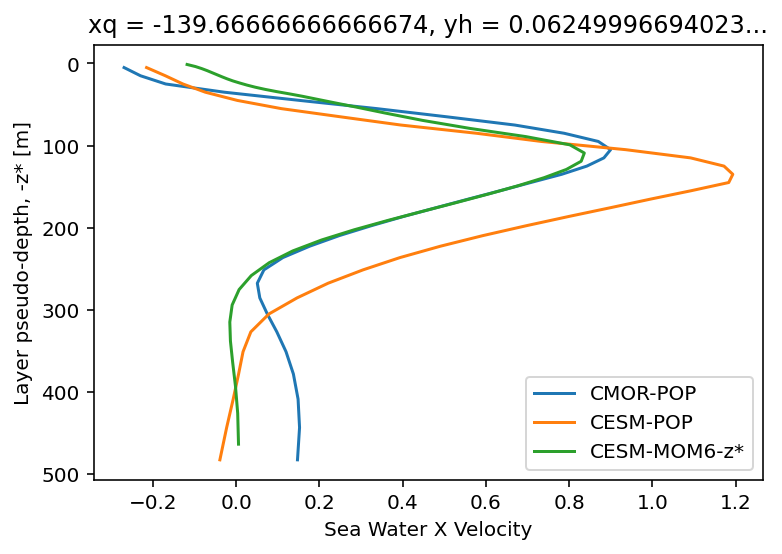

In [94]:
def plot_euc(ds, **plot_kwargs):
    if "nlat" in ds.dims and "nlat" not in ds.coords:
        ds = set_coords(ds)

    # gets UVEL in CESM-POP, "uo" in CESM-MOM6, "uo" in CMOR
    u = ds.cf["sea_water_x_velocity"]

    # find the z-coordinate name: "z_t" in CESM-POP, "lev" in CMOR, "zl" in CESM-MOM6
    Zname = u.cf.coordinates["vertical"][0]

    u = (
        u.metpy.quantify()  # attach units
        .pint.to("m/s")  # convert velocity to m/s
        .metpy.convert_coordinate_units(Zname, "m")  # convert the Z-coordinate to m
    )

    # --- find (0, -140)
    lat = u.cf["latitude"]  # gets possibly 2D latitude variable
    lon = u.cf["longitude"]
    # TODO: Xarray will provide a better solution here in ≈ 6 months
    #     right now, we need to know
    if bool(np.all(lon.data > 0)):
        lon_target = 220
    else:
        lon_target = -140
    lat_target = 0

    if lon.ndim == 2:
        # find index corresponding to (0, -140)
        ilat, ilon = np.unravel_index(
            np.argmin(((lat - lat_target) ** 2 + (lon - lon_target) ** 2).values),
            lon.shape,
        )
        # TODO: .isel(X=ilon, Y=ilat) does not work
        # because for the CMOR dataset, "lon" and "nlon" both have axis="X"
        u_sub = u.cf.isel({"X": ilon, "Y": ilat})
    else:
        u_sub = u.cf.sel({"X": lon_target, "Y": lat_target}, method="nearest")

    # now plot the last year for demonstration
    # All datasets here use "time" for the time axis,
    # so using .cf.mean("time") is really just for demo purposes
    (
        u_sub.cf.sel(vertical=slice(500))  # top 500m
        .cf.isel(time=slice(-12, None))
        .cf.mean("time")
        .cf.plot(**plot_kwargs)  # puts 'Z' on the y-axis automatically and
        # makes sure values increase downward (since attrs["positive"] == "down")
    )


plot_euc(cmor, label="CMOR-POP")
plot_euc(cesm, label="CESM-POP")
plot_euc(mom6zs, label="CESM-MOM6-z*")
plt.legend()